# AOS ComCam Zernikes

Notebook Owner: **Bryce Kalmbach** ([@jbkalmbach](https://github.com/lsst-ts/ts_analysis_notebooks/issues/new?body=@jbkalmbach)) <br>
Last Verified to Run: **5/3/2021** <br>
Verified Stack Release: **w_2021_18**

In [2]:
# Should match verified version above
! eups list -s lsst_distrib

   21.0.0-2-g8e5b5ee+be16eab377 	current w_2021_18 setup


In [3]:
! eups list ts_wep

   LOCAL:/home/brycek/notebooks/Commissioning/aos/ts_wep 	setup


## Notebook Goal
Demonstrate the processing of wave front images for ComCam from raw to Zernikes.

## Installation

This notebook requires the LSST Science Pipelines as well as the following telescope and site packages: 
- `phosim_utils` (Only as a prerequisite for `ts_wep`. None of the code shown here uses it.)
- `ts_wep`

### Installing `phosim_utils` and `ts_wep` on **Rubin Science Platform**

`phosim_utils` is available on GitHub [here](https://github.com/lsst-dm/phosim_utils) and `ts_wep` is available [here](https://github.com/lsst-ts/ts_wep). 

To install on **RSP** open a terminal in the notebook aspect: 
1. Set up the LSST Science Pipelines: 

```
source ${LOADSTACK}
setup lsst_distrib
```

2. Go the directory you would like to install the packages and clone the `ts_phosim` and `ts_wep` repositories from the GitHub links above.
3. Inside the `phosim_utils` directory run the following to build the module:

```
setup -k -r .
scons
```

4. Repeat the same commands inside the `ts_wep` repository.
5. Add the following to your `${HOME}/notebooks/.user_setups` to run `ts_wep` in an **RSP** notebook:

```
setup -k -r {PATH_TO_PHOSIM_UTILS}
setup -k -r {PATH_TO_TS_WEP}
```
6. Restart notebook kernel and continue with the notebook.

## Run pipeline

### Pipeline Set Up

To run the full pipeline we can use the pipeline YAML file available for testing in `comCamPipeline.yaml` here in this directory. Here is what is in that file with comments:

In [4]:
! cat comCamPipeline.yaml

# This yaml file is used to define the tasks and configuration of
# a Gen 3 pipeline used for testing in ts_wep.
description: wep basic processing test pipeline
# Here we specify the corresponding instrument for the data we
# will be using.
instrument: lsst.obs.lsst.LsstComCam
# Then we can specify each task in our pipeline by a name
# and then specify the class name corresponding to that task
tasks:
  isr:
    class: lsst.ip.isr.isrTask.IsrTask
    # Below we specify the configuration settings we want to use
    # when running the task in this pipeline. Since our data doesn't
    # include bias or flats we only want to use doApplyGains and
    # doOverscan in our isr task.
    config:
      connections.outputExposure: 'postISRCCD'
      doBias: False
      doVariance: False
      doLinearize: False
      doCrosstalk: False
      doDefect: False
      doNanMasking: False
      doInterpolate: False
      doBrighterFatter: False
      doDark: False
      doFlat: False
      doApplyGains:

### Run task from command line

Now we will run this pipeline using the `pipetask run` command available on the command line.

In [79]:
# Some basic imports
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# This allows us to run command line tasks from inside the notebook easier
from lsst.ts.wep.Utility import runProgram, writePipetaskCmd, writeCleanUpRepoCmd

# Location of ts_wep
ts_wep_dir = os.environ['TS_WEP_DIR']

# Import Gen 3 Butler
from lsst.daf import butler as dafButler

#### Building our shell command

We need the following to specify our command:

In [10]:
# First specify the repository location
repoDir = '/project/brycek/aos/data/repo_043021/DATA'
# Next we create a name for the output of our pipeline run
runName = 'notebook_test'
# We are going to use comcam data so we specify the correct instrument
instrument = 'lsst.obs.lsst.LsstComCam'
# Tell the pipeline which existing data in the repository to use
collections = 'refcats,LSSTComCam/raw/all,LSSTComCam/calib'
# And finally the file that specifies our pipeline tasks and configurations shown above
pipelineYaml = 'comCamPipeline.yaml'

Let's take a brief look inside our data repository by looking at the `butler.registry`

In [14]:
butler = dafButler.Butler(repoDir)
registry = butler.registry

In [18]:
# What exposures are ingested already?
for dataId in registry.queryDataIds('exposure'):
    print(dataId)

{instrument: 'LSSTComCam', exposure: 4000021706001, ...}
{instrument: 'LSSTComCam', exposure: 4000021706002, ...}
{instrument: 'LSSTComCam', exposure: 4000021706000, ...}


We see that there are a number of `LSSTComCam` exposures available. We only want the extra-focal and intra-focal exposures: `4000021706001` and `4000021706002`. So we will specify those when building our command below
with the help from the function `writePipetaskCmd` available in `ts_wep`.

In [48]:
# Use the utility function in ts_wep to write our pipeline task command
runPipeTaskCmd = writePipetaskCmd(repoDir, runName, instrument, collections, pipelineYaml=pipelineYaml)

In [49]:
# Add command to grab the specific extra-focal and intra-focal exposures we want to use
runPipeTaskCmd += ' -d "exposure IN (4000021706001, 4000021706002)"'

What does the full command look like?

In [50]:
print(runPipeTaskCmd)

pipetask run -b /project/brycek/aos/data/repo_043021/DATA -i refcats,LSSTComCam/raw/all,LSSTComCam/calib --instrument lsst.obs.lsst.LsstComCam --register-dataset-types --output-run notebook_test -p comCamPipeline.yaml -d "exposure IN (4000021706001, 4000021706002)"


In [ ]:
# Run pipetask (This may take a while.)
! {runPipeTaskCmd}

## Exploring Output

After our task runs we can now look at the new output saved in our data repository and accessible by the `butler`.

First, we need reload the butler to get the updated registry.

In [56]:
butler = dafButler.Butler(repoDir)
registry = butler.registry

We can run `queryCollections` to see the available datasets and see that there is now a dataset called `notebook_test` available.

In [55]:
for x in registry.queryCollections():
    print(x)

LSSTCam/raw/all
LSSTCam/calib
LSSTCam/calib/unbounded
refcats/gen2
refcats
LSSTCam/defaults
skymaps
LSSTComCam/raw/all
LSSTComCam/calib
LSSTComCam/calib/unbounded
notebook_test


We can also look inside the registry to see the available dataset types. We have added `donutCatalog`, `donutStampsExtra`, `donutStampsIntra` and `zernikeEstimate`.

In [57]:
dataTypes = registry.queryDatasetTypes()
for dataType in dataTypes:
    print(dataType)

DatasetType('camera', {instrument}, Camera, isCalibration=True)
DatasetType('cal_ref_cat', {htm7}, SimpleCatalog)
DatasetType('raw', {band, instrument, detector, physical_filter, exposure}, Exposure)
DatasetType('postISRCCD', {band, instrument, detector, physical_filter, exposure}, Exposure)
DatasetType('donutCatalog', {instrument}, DataFrame)
DatasetType('isr_metadata', {band, instrument, detector, physical_filter, exposure}, PropertySet)
DatasetType('donutStampsIntra', {band, instrument, detector, physical_filter, exposure}, StampsBase)
DatasetType('donutStampsExtra', {band, instrument, detector, physical_filter, exposure}, StampsBase)
DatasetType('zernikeEstimate', {band, instrument, detector, physical_filter, exposure}, NumpyArray)
DatasetType('estimateZernikesFamTask_metadata', {instrument, detector}, PropertySet)
DatasetType('generateDonutCatalogOnlineTask_metadata', {instrument}, PropertySet)
DatasetType('isr_config', {}, Config)
DatasetType('estimateZernikesFamTask_config', {},

To start exploring the new data products let's pick a `dataId` from inside `notebook_test` with an available `postISRCCD`.

In [62]:
datasetRefs = list(registry.queryDatasets(datasetType='postISRCCD', collections=[runName]))
for ref in datasetRefs:
    print(ref.dataId)

{instrument: 'LSSTComCam', detector: 1, exposure: 4000021706001, ...}
{instrument: 'LSSTComCam', detector: 8, exposure: 4000021706002, ...}
{instrument: 'LSSTComCam', detector: 7, exposure: 4000021706001, ...}
{instrument: 'LSSTComCam', detector: 3, exposure: 4000021706002, ...}
{instrument: 'LSSTComCam', detector: 0, exposure: 4000021706002, ...}
{instrument: 'LSSTComCam', detector: 4, exposure: 4000021706001, ...}
{instrument: 'LSSTComCam', detector: 5, exposure: 4000021706001, ...}
{instrument: 'LSSTComCam', detector: 1, exposure: 4000021706002, ...}
{instrument: 'LSSTComCam', detector: 7, exposure: 4000021706002, ...}
{instrument: 'LSSTComCam', detector: 2, exposure: 4000021706002, ...}
{instrument: 'LSSTComCam', detector: 8, exposure: 4000021706001, ...}
{instrument: 'LSSTComCam', detector: 4, exposure: 4000021706002, ...}
{instrument: 'LSSTComCam', detector: 3, exposure: 4000021706001, ...}
{instrument: 'LSSTComCam', detector: 6, exposure: 4000021706002, ...}
{instrument: 'LSSTCo

In [63]:
dataId = {'instrument': 'LSSTComCam', 'detector': 4, 'exposure': 4000021706001}

### Load a postISR image

In [61]:
postIsrExp = butler.get('postISRCCD', dataId=dataId, collections=[runName])

Text(0, 0.5, 'Y Pixel')

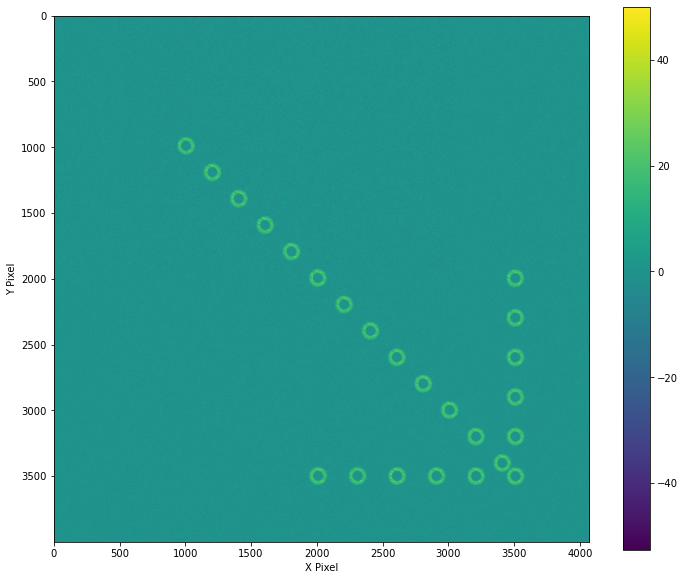

In [75]:
fig = plt.figure(figsize=(12, 10))
plt.imshow(postIsrExp.image.array, vmax=50)
plt.colorbar()
plt.xlabel('X Pixel')
plt.ylabel('Y Pixel')

### Load the donut catalog for an exposure

In [65]:
srcCat = butler.get('donutCatalog', dataId=dataId, collections=[runName])

In [66]:
srcCat

,coord_ra,coord_dec,centroid_x,centroid_y,detector
0,6.280523,-0.004137,1994.992540,3479.719512,R22_S00
1,6.280523,-0.003846,2295.328396,3480.169516,R22_S00
2,6.280524,-0.003554,2595.663578,3480.619519,R22_S00
3,6.280524,-0.003263,2895.980137,3481.069522,R22_S00
4,6.280525,-0.002972,3196.314126,3481.519525,R22_S00
...,...,...,...,...,...
211,0.004893,0.004850,2813.529100,2821.912275,R22_S22
212,0.005088,0.005044,3014.043467,3022.869280,R22_S22
213,0.005283,0.005239,3214.558823,3223.826684,R22_S22
214,0.005478,0.005433,3415.075205,3424.766501,R22_S22


Let's make sure our `donutCatalog` is correct.

In [67]:
exposureName = postIsrExp.getDetector().getName()

In [68]:
expCatalog = srcCat.query(f'detector == "{exposureName}"')

Text(0, 0.5, 'Y Pixel')

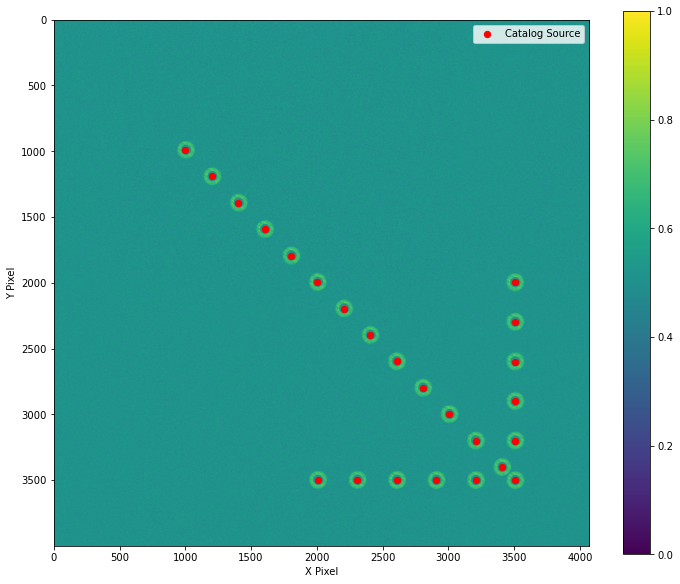

In [76]:
fig = plt.figure(figsize=(12, 10))
plt.imshow(postIsrExp.image.array, vmax=50)
plt.scatter(expCatalog['centroid_x'], expCatalog['centroid_y'], c='r', s=40, label='Catalog Source')
plt.colorbar()
plt.legend()
plt.xlabel('X Pixel')
plt.ylabel('Y Pixel')

### Look at the `donutStamps`

In [71]:
extraFocalStamps = butler.get('donutStampsExtra', dataId=dataId, collections=[runName])

The `donutStamps` objects contain the postage stamps as `lsst.afw.image.MaskedImage` objects along with extra metadata. Here we will load the image from one of the objects.

Text(0, 0.5, 'Y Pixel')

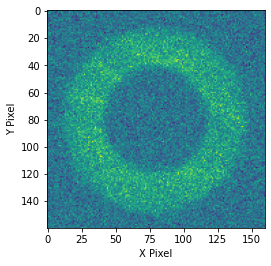

In [77]:
plt.imshow(extraFocalStamps[0].stamp_im.image.getArray())
plt.xlabel('X Pixel')
plt.ylabel('Y Pixel')

### Load the Zernike coefficients

In [81]:
zerCoeff = butler.get('zernikeEstimate', dataId=dataId, collections=[runName])

In [82]:
zerCoeff

array([-0.09414765,  0.22176907,  0.35695835, -0.14169595, -0.12573395,
        0.05473251,  0.12916113,  0.02775479, -0.05795376, -0.00067889,
       -0.07260545, -0.08785945,  0.00652746,  0.03758638, -0.04504362,
        0.06458629,  0.1183083 , -0.02780642,  0.01546785])

Text(0, 0.5, 'Zernike Coefficient (microns)')

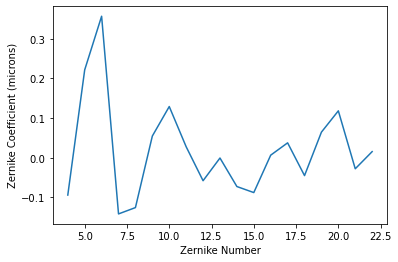

In [84]:
plt.plot(np.arange(4, 23), zerCoeff)
plt.xlabel('Zernike Number')
plt.ylabel('Zernike Coefficient (microns)')